# Breakpoint Detection

Performs the breakpoint detection on the genome signal and shows the overlaps between the detected breakpoints, the ground truth signal and the original signal.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns;
from collections import Counter
import glob
%matplotlib inline
sns.set(rc={'figure.figsize':(8.7,6.27)})

In [2]:
def plot_overlapping_signals(mat0, mat1, min_val, max_val, chr_pos=None, chr_texts=None): # Todo: have chr pos and chr text visualised
    plt.figure(figsize=(20,10))
    plt.subplots_adjust(left=None, bottom=-0.3, right=None, top=None, wspace=None, hspace=None)
    ax = plt.subplot(211)
    ax.plot(mat0,'b--')
    ax.plot(mat1,'g--')
    ax.axis([None, None, min_val, max_val])
    if chr_pos is not None:
        for i,pos in enumerate(chr_pos):
            ax.annotate(chr_texts[i], xy=(pos, -0.001),rotation=0, rotation_mode="anchor")
            ax.axvline(x=pos, ymin=0, ymax=1, ls='dashed', color='black', lw='0.2')
    ax.get_xaxis().set_visible(False)
    #ax.legend(loc='upper left')
    plt.show()


def plot_1d_signal(mat,  min_val, max_val, chr_pos=None, chr_texts=None): # Todo: have chr pos and chr text visualised
    plt.figure(figsize=(20,10))
    plt.subplots_adjust(left=None, bottom=-0.3, right=None, top=None, wspace=None, hspace=None)
    ax = plt.subplot(311)
    ax.plot(mat,'b--')
    ax.axis([None, None, min_val, max_val])
    if chr_pos is not None:
        for i,pos in enumerate(chr_pos):
            ax.annotate(chr_texts[i], xy=(pos, -0.001),rotation=0, rotation_mode="anchor")
            ax.axvline(x=pos, ymin=0, ymax=1, ls='dashed', color='black', lw='0.2')
    ax.get_xaxis().set_visible(False)
    #ax.legend(loc='upper left')
    plt.show()
    

### Parsing the input

#### Ground truth 

In [3]:
gt = pd.read_csv('./sp_simulations_data/50regions_50nodes_sim_ground_truth.txt',header=None, sep=' ')

In [4]:
gt = gt.iloc[:, :-1] # remove the last None column

In [5]:
ground_truth_avg = gt.mean(0)

In [6]:
ground_truth_avg.shape

(292,)

#### Region sizes

In [7]:
reg_sizes = pd.read_csv('./sp_simulations_data/50regions_50nodes_sim_sp0_region_sizes.txt', header=None)

In [8]:
reg_sizes = reg_sizes.values.flatten()

In [9]:
len(reg_sizes)

50

In [10]:
reg_sizes

array([ 7,  4,  8,  5,  7, 10,  3,  7,  8,  5,  4,  8,  8,  3,  6,  5,  2,
        8,  6,  2,  5,  1, 10,  6,  9,  1, 10,  3,  7,  4,  9,  3,  5,  3,
        7,  5,  9,  7,  2,  4,  9,  2, 10,  9, 10,  5,  2,  4,  7,  8])

In [11]:
breakpoints = []
cum_rs = 0
for rs in reg_sizes:
    cum_rs += rs
    breakpoints.append(cum_rs)

In [12]:
assert(len(breakpoints) == len(reg_sizes))

#### Dynamic programming results (sp vector)

In [13]:
df0 = pd.read_csv('./sp_simulations_data/50regions_50nodes_sim_sp0.txt',header=None)
df1 = pd.read_csv('./sp_simulations_data/50regions_50nodes_sim_sp1.txt',header=None)

In [14]:
df1.shape

(292, 1)

#### Sp signal

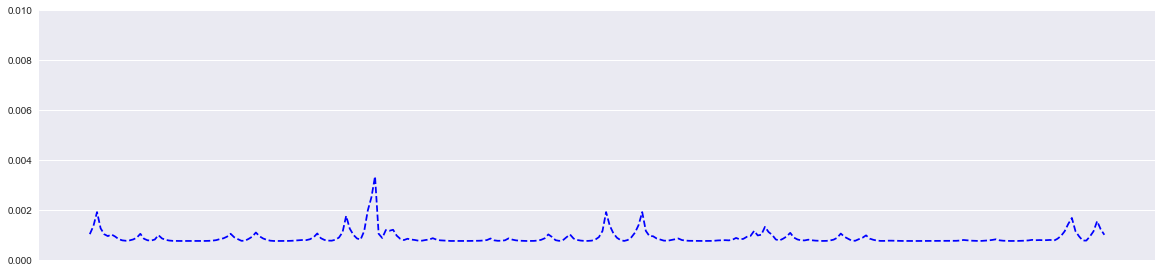

In [15]:
plot_1d_signal(df1[5:-5].values, 0.0000, 0.01)

#### Histogram of the sp signal 

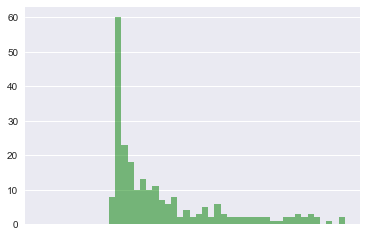

In [16]:
bins = np.linspace(0.0007, 0.001)
fig, ax = plt.subplots()
hist = ax.hist(df1[5:-5].values, bins, alpha=0.5, color='g', label='mag of g')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))

#### Histogram of the null sp model

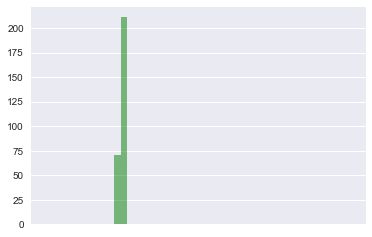

In [17]:
fig, ax = plt.subplots()
hist = ax.hist(df0[5:-5].values, bins, alpha=0.5, color='g', label='mag of g')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))

### Remove window offsets
Removes the window offset from both sp signals.

In [18]:
window_size = 5

In [19]:
sp_null = df0[window_size:window_size*-1].values.flatten()

In [20]:
sp = df1[window_size:window_size*-1].values.flatten()

In [21]:
w_breakpoints = [bp-window_size for bp in breakpoints] # subtract the window size
w_breakpoints[-1] -= window_size # also from the other end

In [22]:
ground_truth_avg = ground_truth_avg[5:-5]

#### Before 
sp_null signal:

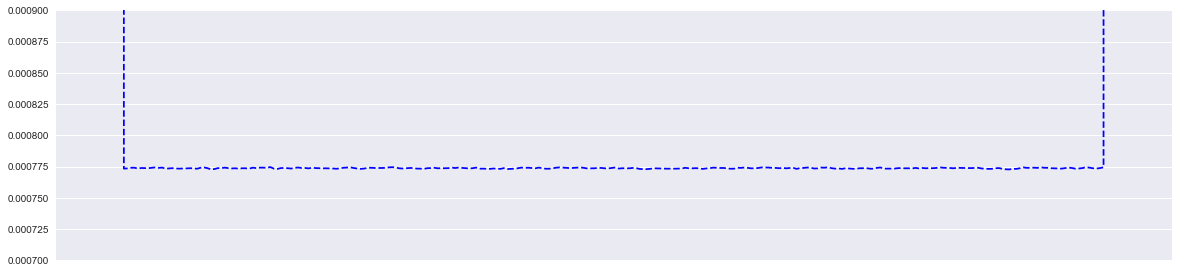

In [23]:
plot_1d_signal(df0.values, 0.0007, 0.0009)

#### After
sp_null signal:

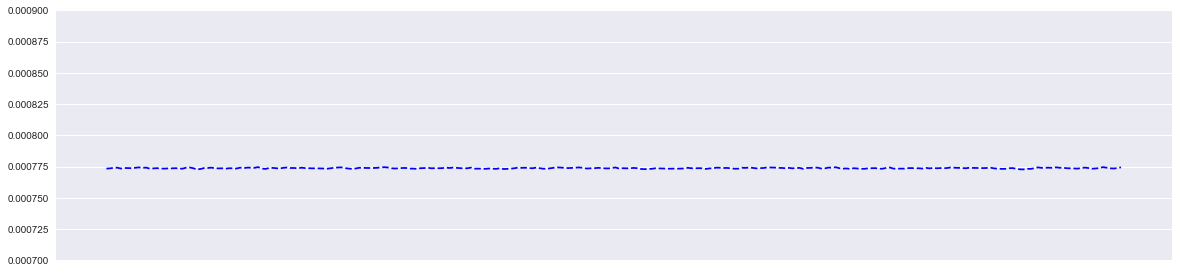

In [24]:
plot_1d_signal(sp_null, 0.0007, 0.0009)

### Make both signals zero mean
This will help us attenuate the peaks below the threshold to the mean value.

In [25]:
sp = sp - sp.mean()
sp_null = sp_null - sp_null.mean()

In [26]:
ground_truth_avg = ground_truth_avg - ground_truth_avg.mean()

### Sort the s_p_null signal
The signal is sorted in order to select the value at a given percentile

In [27]:
s_sp_null = sorted(sp_null)
len(s_sp_null)

282

#### Select 99.99 percentile

In [28]:
percentile = int(0.999 * (len(s_sp_null)-1))
percentile

280

In [29]:
sp_threshold = s_sp_null[percentile]
sp_threshold

8.435106382978595e-07

### Select the values in the original signal above the threshold 

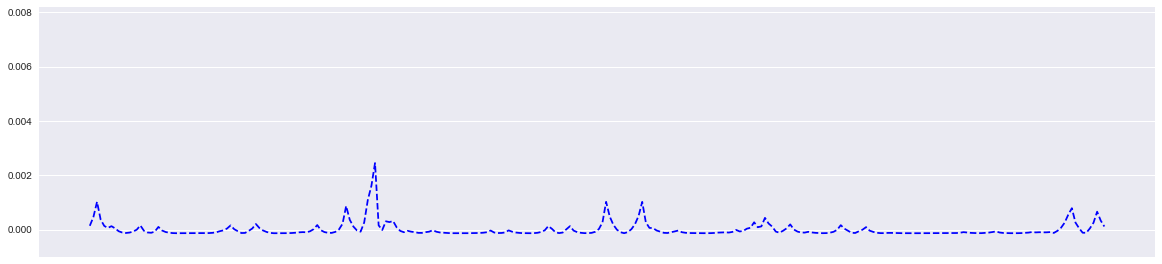

In [30]:
plot_1d_signal(sp, -0.0010, 0.0082)

#### The number of data points to be attenuated

In [31]:
len(sp) - sum(sp<sp_threshold)

73

In [32]:
sp.min()

-0.00013230307801418448

#### Attenuate the filtered values to the mean value

In [33]:
sp[sp<sp_threshold] = 0

In [34]:
sp.min()

0.0

#### The attenuated sp signal

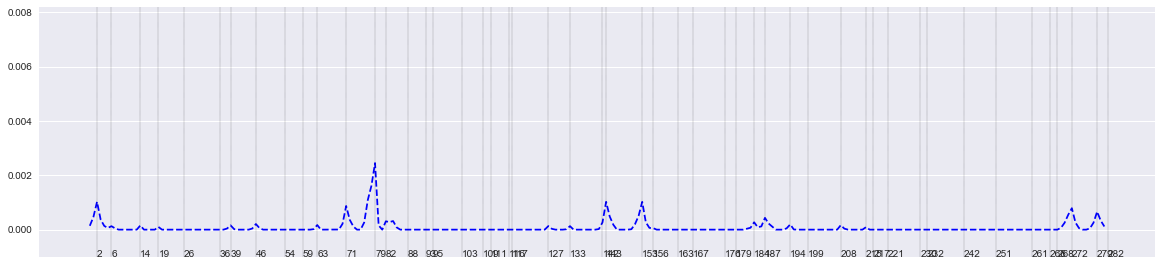

In [35]:
plot_1d_signal(sp, -0.0010, 0.0082, w_breakpoints, w_breakpoints)

In [36]:
type(sp)

numpy.ndarray

In [37]:
# writing sp to file
np.savetxt('sp_matrix_threshold_removed.txt',sp)

### Find the local maximas using convolution
The peaks (local maximas) are at the -2 values. 

In [38]:
sp_peaks = np.diff(np.sign(np.diff(sp,axis=0)),axis=0)

#### The number of local maximas are denoted by the -2.0 key of the dictionary

In [39]:
print(dict(map(lambda x  : (x , list(sp_peaks).count(x)) , sp_peaks)))

{0.0: 220, -2.0: 22, 2.0: 4, 1.0: 34}


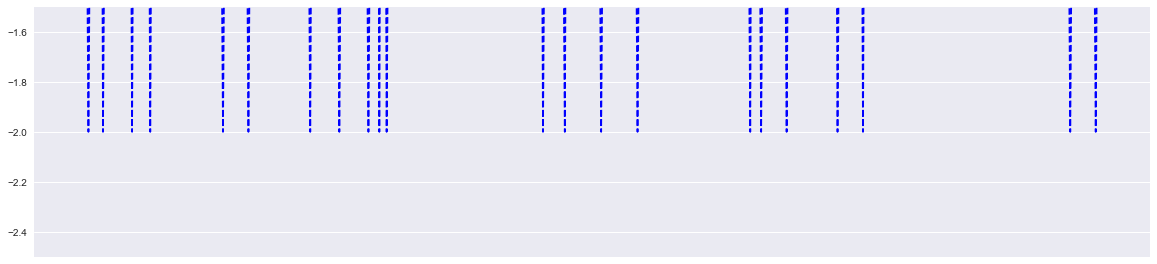

In [40]:
plot_1d_signal(sp_peaks, -2.5, -1.5)

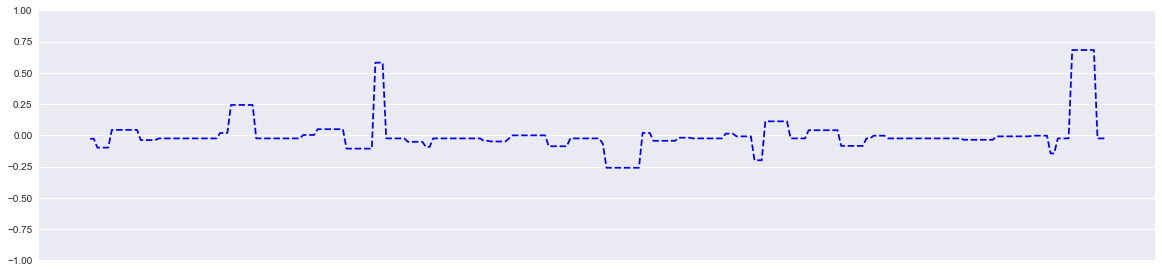

In [41]:
plot_1d_signal(ground_truth_avg,-1,1)

#### Keeping only the local maximas

In [42]:
sp_peaks[sp_peaks > -2] = 0

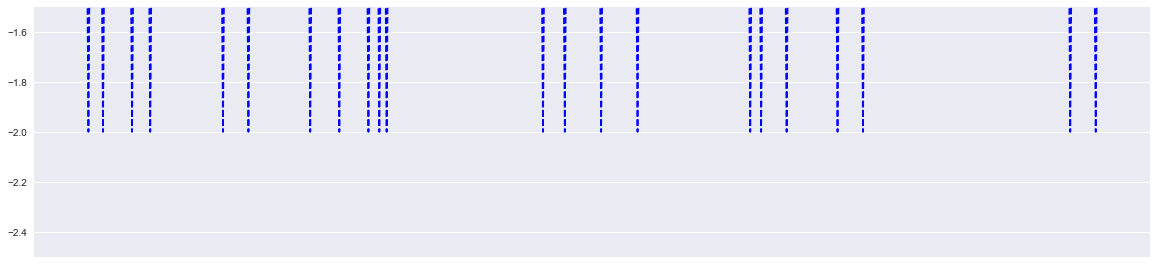

In [43]:
plot_1d_signal(sp_peaks, -2.5, -1.5)

#### The lengths differ due to convolution

In [44]:
len(ground_truth_avg)

282

In [45]:
len(sp_peaks)

280

### Plotting the breakpoints over the ground truth
Green denotes the breakpoints, while blue is denoting the mean of the ground truth signal.
This plot shows how the breakpoints match the ground truth.
1 unit padding is needed after convolution.

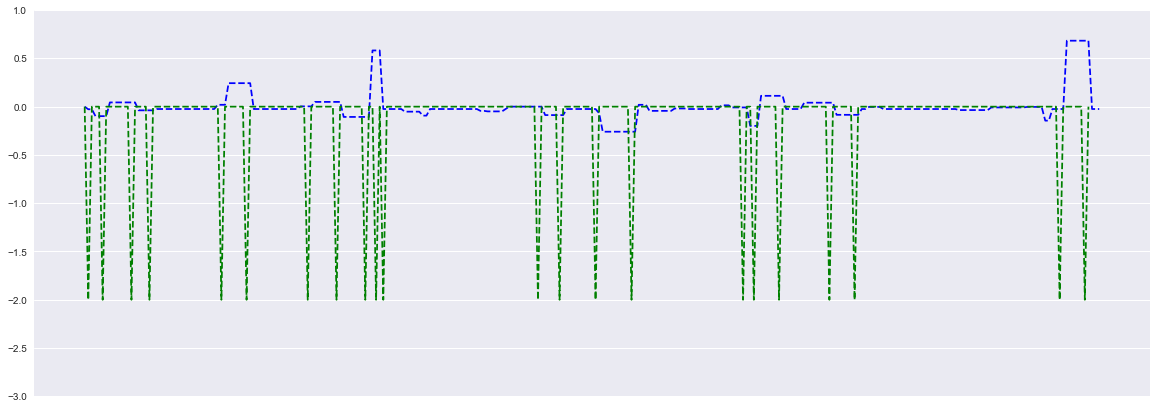

In [46]:
plot_overlapping_signals([0] + list(ground_truth_avg), sp_peaks, -3,1)

### Plotting the overlaps between the original sp signal and the peaks detected by convolution

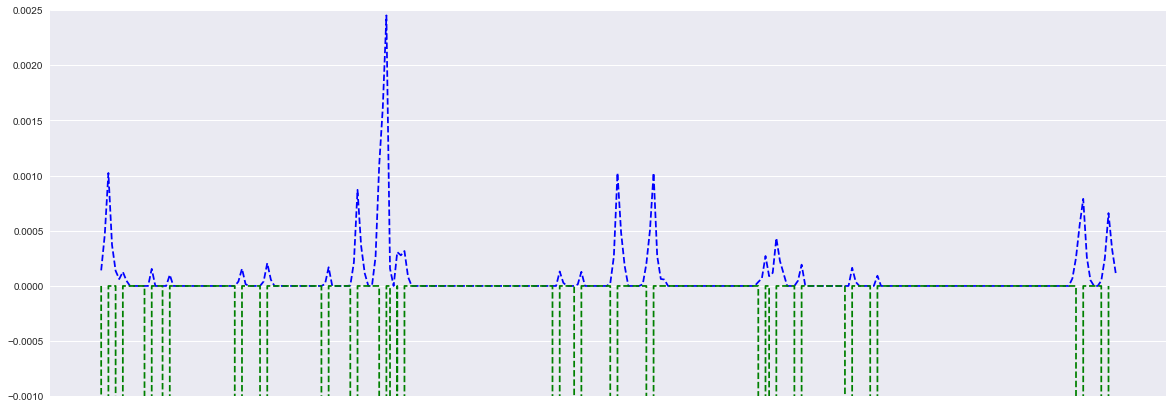

In [47]:
plot_overlapping_signals(sp, sp_peaks, -0.001,0.0025)

#### Better visualisation

In [48]:
_sp_peaks = np.copy(sp_peaks)

In [49]:
_sp_peaks[_sp_peaks == -2] = -0.0002

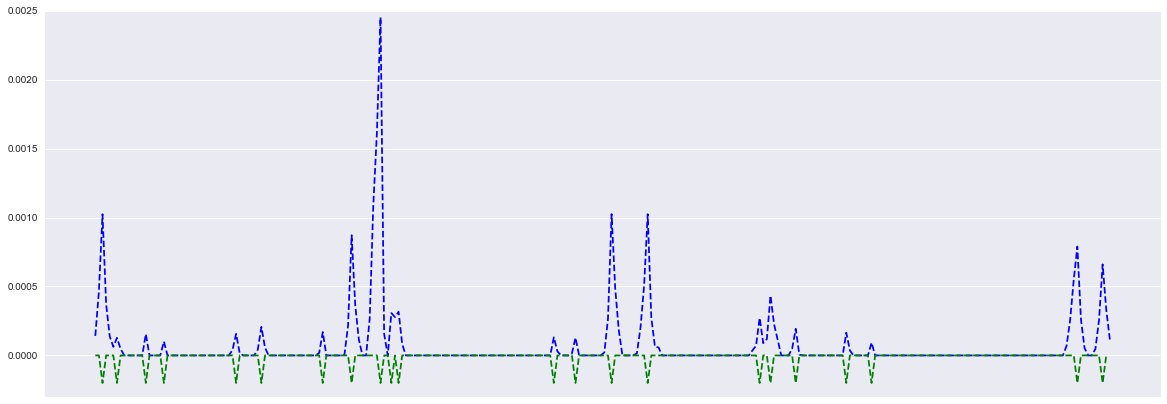

In [53]:
plot_overlapping_signals(sp, [0] + list(_sp_peaks), -0.0003,0.0025)